<a href="https://colab.research.google.com/github/serjankaur05/ML-for-EEG-Data/blob/main/Machine_Learning_to_Analyze_EEG_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne
!pip install sklearn
!pip install matplotlib
!pip install torch 
!pip install torchvision
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 20.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=9c54a7513c7e59a365cce9b6903c1e0b4714adaf0aa0f60088f44d9298bd7c41
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 15.0 MB/s 


In [ ]:
from collections import OrderedDict
from pylab import rcParams
import torch
import torch.nn as nn
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import mne
from sklearn.preprocessing import RobustScaler
torch.manual_seed(100) #Set randomizer seed for consistency

In [ ]:
eeg_sample_count = 240 
learning_rate = 1e-3
eeg_sample_length = 226 
number_of_classes = 1
hidden1 = 500 
hidden2 = 1000 
hidden3 = 100 
output = 10 

In [ ]:
## Define the network
tutorial_model = nn.Sequential()

# Input Layer (Size 226 -> 500)
tutorial_model.add_module('Input Linear', nn.Linear(eeg_sample_length, hidden1))
tutorial_model.add_module('Input Activation', nn.CELU()) 

# Hidden Layer (Size 500 -> 1000)
tutorial_model.add_module('Hidden Linear', nn.Linear(hidden1, hidden2))
tutorial_model.add_module('Hidden Activation', nn.ReLU())

# Hidden Layer (Size 1000 -> 100)
tutorial_model.add_module('Hidden Linear2', nn.Linear(hidden2, hidden3))
tutorial_model.add_module('Hidden Activation2', nn.ReLU())

# Hidden Layer (Size 100 -> 10)
tutorial_model.add_module('Hidden Linear3', nn.Linear(hidden3, 10))
tutorial_model.add_module('Hidden Activation3', nn.ReLU())

# Output Layer (Size 10 -> 1)
tutorial_model.add_module('Output Linear', nn.Linear(10, number_of_classes))
tutorial_model.add_module('Output Activation', nn.Sigmoid())

In [ ]:
# Define a loss function
loss_function = torch.nn.MSELoss()

# Define a training procedure
def train_network(train_data, actual_class, iterations):

  # Keep track of loss at every training iteration
  loss_data = []

  # Begin training for a certain amount of iterations
  for i in range(iterations):

    # Begin with a classification
    classification = tutorial_model(train_data)

    # Find out how wrong the network was
    loss = loss_function(classification, actual_class)
    loss_data.append(loss)

    # Zero out the optimizer gradients every iteration
    optimizer.zero_grad()

    # Teach the network how to do better next time
    loss.backward()
    optimizer.step()

     # Plot a nice loss graph at the end of training
  rcParams['figure.figsize'] = 10, 5
  plt.title("Loss vs Iterations")
  plt.plot(list(range(0, len(loss_data))), loss_data)
  plt.show()

# Save the network's default state so we can retrain from the default weights
torch.save(tutorial_model, "/home/tutorial_model_default_state")

In [ ]:
## Create sample data using the parameters
sample_positives = [None, None] # Element [0] is the sample, Element [1] is the class
sample_positives[0] = torch.rand(int(eeg_sample_count / 2), eeg_sample_length) * 0.50 + 0.25
sample_positives[1] = torch.ones([int(eeg_sample_count / 2), 1], dtype=torch.float32)

sample_negatives = [None, None] # Element [0] is the sample, Element [1] is the class
sample_negatives_low = torch.rand(int(eeg_sample_count / 4), eeg_sample_length) * 0.25
sample_negatives_high = torch.rand(int(eeg_sample_count / 4), eeg_sample_length) * 0.25 + 0.75
sample_negatives[0] = torch.cat([sample_negatives_low, sample_negatives_high], dim = 0)
sample_negatives[1] = torch.zeros([int(eeg_sample_count / 2), 1], dtype=torch.float32)

samples = [None, None] # Combine the two
samples[0] = torch.cat([sample_positives[0], sample_negatives[0]], dim = 0)
samples[1] = torch.cat([sample_positives[1], sample_negatives[1]], dim = 0)

## Create test data that isn't trained on
test_positives = torch.rand(10, eeg_sample_length) * 0.50 + 0.25 # Test 10 good samples
test_negatives_low = torch.rand(5, eeg_sample_length) * 0.25 # Test 5 bad low samples
test_negatives_high = torch.rand(5, eeg_sample_length) * 0.25 + 0.75 # Test 5 bad high samples
test_negatives = torch.cat([test_negatives_low, test_negatives_high], dim = 0)

print("We have created a sample dataset with " + str(samples[0].shape[0]) + " samples")
print("Half of those are positive samples with a score of 100%")
print("Half of those are negative samples with a score of 0%")
print("We have also created two sets of 10 test samples to check the validity of the network")

We have created a sample dataset with 240 samples
Half of those are positive samples with a score of 100%
Half of those are negative samples with a score of 0%
We have also created two sets of 10 test samples to check the validity of the network


In [ ]:
# understanding the data The green line depicts the average of the "good" class 1 samples. You can see that it differs from the "bad" class in having values around 0.5 and a larger amplitude. The red lines at the top and bottom represent two averages of the "bad" class 0 samples. We developed two "bad" classes, each of which was centred either at 0.25 or 0.75 and had a lower amplitude than the "good" classes. Each of these classes' examples is plotted in light grey.
rcParams['figure.figsize'] = 15, 5

plt.title("Sample Data Set")
plt.legend()
plt.plot(list(range(0, eeg_sample_length)), sample_positives[0][0], color = "#bbbbbb", label = "One Sample")
plt.plot(list(range(0, eeg_sample_length)), sample_positives[0].mean(dim = 0), color = "g", label = "Mean Positive")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_high[0], color = "#bbbbbb")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_high.mean(dim = 0), color = "r", label = "Mean Negative")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_low[0], color = "#bbbbbb")
plt.plot(list(range(0, eeg_sample_length)), sample_negatives_low.mean(dim = 0), color = "r")
plt.plot(list(range(0, eeg_sample_length)), [0.75] * eeg_sample_length, color = "k")
plt.plot(list(range(0, eeg_sample_length)), [0.25] * eeg_sample_length, color = "k")
plt.show()
#If the network classifies this data correctly, it will be more likely to classify the actual, and more complicated, dataset correctly.

Positive Test 1 Value scored: 54.77%
Positive Test 2 Value scored: 54.73%
Positive Test 3 Value scored: 54.74%
Positive Test 4 Value scored: 54.78%
Positive Test 5 Value scored: 54.72%
Positive Test 6 Value scored: 54.69%
Positive Test 7 Value scored: 54.73%
Positive Test 8 Value scored: 54.66%
Positive Test 9 Value scored: 54.78%
Positive Test 10 Value scored: 54.69%

Negative Test 1 Value scored: 54.59%
Negative Test 2 Value scored: 54.58%
Negative Test 3 Value scored: 54.53%
Negative Test 4 Value scored: 54.58%
Negative Test 5 Value scored: 54.56%
Negative Test 6 Value scored: 54.87%
Negative Test 7 Value scored: 54.87%
Negative Test 8 Value scored: 54.89%
Negative Test 9 Value scored: 54.88%
Negative Test 10 Value scored: 54.87%

Below is a scatter plot of some of the samples
Notice the distinct areas of red and green dots. If the input of this 
network was a simple x and y coordinate, the square band in the center would 
represent the "solution space" of our network. However, an a

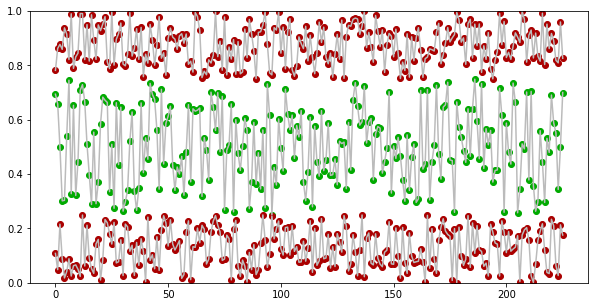

In [ ]:
# Classify our positive test dataset
predicted_positives = tutorial_model(test_positives).data.tolist()

# Print the results
for index, value in enumerate(predicted_positives):
  print("Positive Test {1} Value scored: {0:.2f}%".format(value[0] * 100, index + 1))

print()

#Classify the negative test dataset
predicted_negatives = tutorial_model(test_negatives).data.tolist()

# Print the results
for index, value in enumerate(predicted_negatives):
  print("Negative Test {1} Value scored: {0:.2f}%".format(value[0] * 100, index + 1))

print()

print("Below is a scatter plot of some of the samples")
print("Notice the distinct areas of red and green dots. If the input of this \n" +
"network was a simple x and y coordinate, the square band in the center would \n" +
"represent the \"solution space\" of our network. However, an actual EEG signal \n" +
"sample is an array of several points and can cross the boundary at any time.")
print("Plotted is one positive sample in green and two negative samples in red")

rcParams['figure.figsize'] = 10, 5
plt.scatter(list(range(0, eeg_sample_length)), test_positives[3], color = "#00aa00")
plt.plot(list(range(0, eeg_sample_length)), test_positives[3], color = "#bbbbbb")
plt.scatter(list(range(0, eeg_sample_length)), test_negatives[0], color = "#aa0000")
plt.plot(list(range(0, eeg_sample_length)), test_negatives[0], color = "#bbbbbb")
plt.scatter(list(range(0, eeg_sample_length)), test_negatives[9], color = "#aa0000")
plt.plot(list(range(0, eeg_sample_length)), test_negatives[9], color = "#bbbbbb")
plt.ylim([0 , 1])
plt.show()

In [ ]:
data_path = mne.datasets.sample.data_path()
data_path

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.06TB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


PosixPath('/root/mne_data/MNE-sample-data')

In [ ]:
from pathlib import Path
import mne

# Set the path to the data directory
data_path = Path('/path/to/data/directory')

# Construct the file paths using the data_path variable
raw_fname = data_path / 'MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path / 'MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

# Read the raw data file and preload it into RAM
raw_data = mne.io.read_raw_fif(raw_fname, preload=True) 

# Set the EEG reference to the average of all voltages
raw_data.set_eeg_reference()


In [ ]:
# Define what data we want from the dataset
event_data = raw_data.pick(picks=["eeg","eog"])
picks_eeg_only = mne.pick_types(raw_data.info, 
                                eeg=True, 
                                eog=True, 
                                meg=False, 
                                exclude='bads')

In [ ]:
events = mne.read_events(event_fname)
event_id = 5
tmin = -0.5 
tmax = 1
epochs = mne.Epochs(raw_data, events, event_id, tmin, tmax, proj=True,
                    picks=picks_eeg_only, baseline=(None, 0), preload=True,
                    reject=dict(eeg=100e-6, eog=150e-6), verbose = False)
print(epochs)

FileNotFoundError: ignored

In [ ]:
# This is the channel used to monitor the P300 response
channel = "EEG 058"

# Display a graph of the sensor position we're using
sensor_position_figure = epochs.plot_sensors(show_names=[channel])